In [1]:
#|default_exp resnet

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *

In [3]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(1)

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
next(iter(dls.train))[0].shape, next(iter(dls.valid))[0].shape

(torch.Size([1024, 1, 28, 28]), torch.Size([2048, 1, 28, 28]))

In [6]:
#|export
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

In [7]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

### Deeper CNN

We can add another layer without changing much the `get_model` function by simply adding a first layer at the beginning with a stride of 1, which will conserve the size of the image. We can increase the number of filters of the last CNN layer from 64 to 128:

In [8]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128), norm=nn.BatchNorm2d):
    layers = [conv(1, 8, stride=1, act=act, norm=norm)]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None, norm=norm, bias=True), nn.Flatten()).to(def_device)

In [9]:
set_seed(1)
epochs = 5
lr = 6e-2
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.814,0.683,0,train
0.855,0.478,0,eval
0.888,0.331,1,train
0.874,0.363,1,eval
0.911,0.255,2,train
0.904,0.266,2,eval
0.925,0.211,3,train
0.914,0.236,3,eval
0.943,0.165,4,train
0.920,0.223,4,eval


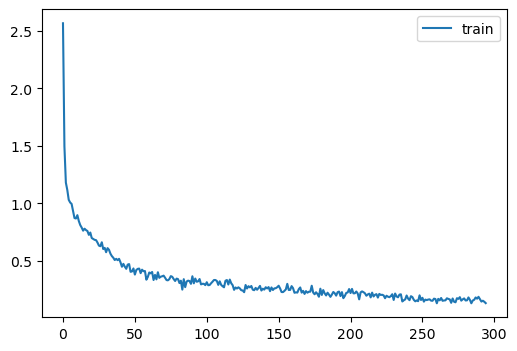

In [14]:
learn.fit(epochs)

This deeper network helped increase the accuracy to 92% after 5 epochs. Deeper networks are better, they can generalize and incorporate higher order non-linear logic the helps discriminate between complex class examples. It should be straight forward to just increase the depth any network. However Kainming He et al. in ['Deep Residual Learning for Image Recognition'](https://arxiv.org/abs/1512.03385) showed that by comparing 20, 34 and 52 deep layers deep networks the accuracy was systematically worse both on the train and test sets for deeper networks. To fix this problem, they introduced a shortcut (or skip) connection between every 2 layer Conv blocks. This structure propagates the input further and emulates the training dynamics of a shallower network : $[In_0] \rightarrow [Conv2d \rightharpoonup Conv2d]_0 \rightarrow [Out_0] + [In_0] = [In_1] \rightarrow [Conv2d \rightharpoonup Conv2d]_1 \rightarrow [Out_1] + [In_1]$

Above we can see that adding a skip connection is equivalent to forcing the two-Conv blocks to find the residual between their input and their output: $$[Out_i] - [In_i] \rightarrow [Conv2d \rightharpoonup Conv2d]_i$$

In order to add $[In]$ and $[Out]$ (the output of the 2 convs), their dimensions should be the same. It works if both `Conv2d`s have the sanme number of filters and a `stride=1`. But if we want to make the number of filters evolve as the depth of the model increases, we need to be able to add the Input regardless of the Conv paremeters. Kaiming He at al. found that wrapping the Input in a $1\times1$-Conv works well by not modifying too much the input tensor but still making sure that the number of filters match the output of the last Conv of the Res Block.

Finally, the activation function is applied on the sum of the output of the Conv layers and the $1\times1$-Conv($In$) in `forward`: 

In [10]:
#|export
def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    return nn.Sequential(conv(ni, nf, stride=1, act=act, norm=norm, ks=ks),
                         conv(nf, nf, stride=stride, act=None, norm=norm, ks=ks))

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act = act()

    def forward(self, x): return self.act(self.convs(x) + self.idconv(self.pool(x)))

In the case of a stride 2 conv layer, we need to compress the input to fit the output size: we can add a pooling layer with stride 1. 

In [11]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 8, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [12]:
Hooks

miniai.activations.Hooks

For larger models, it's always good to look at the model's layers and parameters. We can vizualize the parameters of each layer using the Hooks context manager (nb `10_activations`). We need to create a function with arguments `hook`, `mod`, `inp`, `outp`:

In [13]:
def _print_shape(hook, mod, inp, outp): print(type(mod).__name__, inp[0].shape, outp.shape)

In [14]:
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, cbs=[DeviceCB(), SingleBatchCB()])
with Hooks(model, _print_shape) as hooks: learn.fit(1, train=False)

ResBlock torch.Size([2048, 1, 28, 28]) torch.Size([2048, 8, 28, 28])
ResBlock torch.Size([2048, 8, 28, 28]) torch.Size([2048, 16, 14, 14])
ResBlock torch.Size([2048, 16, 14, 14]) torch.Size([2048, 32, 7, 7])
ResBlock torch.Size([2048, 32, 7, 7]) torch.Size([2048, 64, 4, 4])
ResBlock torch.Size([2048, 64, 4, 4]) torch.Size([2048, 128, 2, 2])
ResBlock torch.Size([2048, 128, 2, 2]) torch.Size([2048, 256, 1, 1])
Flatten torch.Size([2048, 256, 1, 1]) torch.Size([2048, 256])
Linear torch.Size([2048, 256]) torch.Size([2048, 10])
BatchNorm1d torch.Size([2048, 10]) torch.Size([2048, 10])


In [15]:
# fc.patch??

In [16]:
@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|\n|--|--|--|--|\n'
    tot = 0
    def _f(hook, mod, inp, outp):
        nonlocal res,tot
        nparms = sum(o.numel() for o in mod.parameters())
        tot += nparms
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, train=False, cbs=[SingleBatchCB()])
    print("Tot params: ", tot)
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

Note that in the definition of the summary method, when we call the fit method, we set the parameter `train` to `False`. This induces that the Single Batch pass is done with the valid set. The valid set has a batch size of `2*bs`, hence if `bs=1024` the summary will indicate `2048`.

In [17]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Tot params:  1228908


|Module|Input|Output|Num params|
|--|--|--|--|
|ResBlock|(2048, 1, 28, 28)|(2048, 8, 28, 28)|712|
|ResBlock|(2048, 8, 28, 28)|(2048, 16, 14, 14)|3696|
|ResBlock|(2048, 16, 14, 14)|(2048, 32, 7, 7)|14560|
|ResBlock|(2048, 32, 7, 7)|(2048, 64, 4, 4)|57792|
|ResBlock|(2048, 64, 4, 4)|(2048, 128, 2, 2)|230272|
|ResBlock|(2048, 128, 2, 2)|(2048, 256, 1, 1)|919296|
|Flatten|(2048, 256, 1, 1)|(2048, 256)|0|
|Linear|(2048, 256)|(2048, 10)|2560|
|BatchNorm1d|(2048, 10)|(2048, 10)|20|


In [25]:
Learner.lr_find??

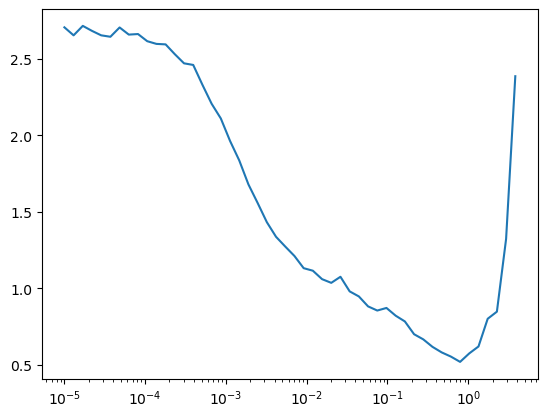

In [26]:
set_seed(1)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
MomentumLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find()

In [18]:
set_seed(1)
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.842,0.607,0,train
0.860,0.429,0,eval
0.893,0.324,1,train
0.857,0.403,1,eval
0.914,0.247,2,train
0.909,0.262,2,eval
0.933,0.192,3,train
0.922,0.220,3,eval
0.952,0.140,4,train
0.931,0.198,4,eval


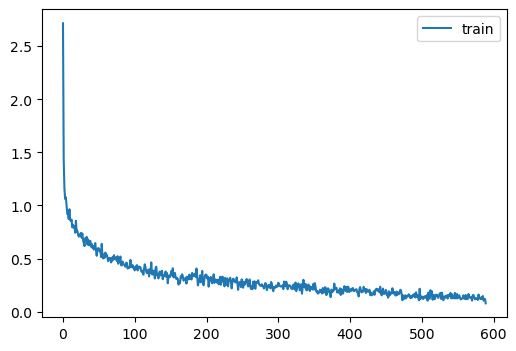

In [62]:
learn.fit(epochs)

In [21]:
m_ = get_model()

In [24]:
[p.shape for p in m_.parameters()]

[torch.Size([8, 1, 3, 3]),
 torch.Size([8]),
 torch.Size([8]),
 torch.Size([8]),
 torch.Size([8, 8, 3, 3]),
 torch.Size([8]),
 torch.Size([8]),
 torch.Size([8]),
 torch.Size([8, 1, 1, 1]),
 torch.Size([8]),
 torch.Size([16, 8, 3, 3]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 16, 3, 3]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 8, 1, 1]),
 torch.Size([16]),
 torch.Size([32, 16, 3, 3]),
 torch.Size([32]),
 torch.Size([32]),
 torch.Size([32]),
 torch.Size([32, 32, 3, 3]),
 torch.Size([32]),
 torch.Size([32]),
 torch.Size([32]),
 torch.Size([32, 16, 1, 1]),
 torch.Size([32]),
 torch.Size([64, 32, 3, 3]),
 torch.Size([64]),
 torch.Size([64]),
 torch.Size([64]),
 torch.Size([64, 64, 3, 3]),
 torch.Size([64]),
 torch.Size([64]),
 torch.Size([64]),
 torch.Size([64, 32, 1, 1]),
 torch.Size([64]),
 torch.Size([128, 64, 3, 3]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128, 128, 3, 3]),
 torch.Size([1

Comparing with resnet models for the `timm` library:

In [42]:
import timm
from timm.models.resnet import BasicBlock, ResNet, Bottleneck

In [43]:
' '.join(timm.list_models('*resnet*'))

'cspresnet50 cspresnet50d cspresnet50w eca_resnet33ts ecaresnet26t ecaresnet50d ecaresnet50d_pruned ecaresnet50t ecaresnet101d ecaresnet101d_pruned ecaresnet200d ecaresnet269d ecaresnetlight gcresnet33ts gcresnet50t inception_resnet_v2 lambda_resnet26rpt_256 lambda_resnet26t lambda_resnet50ts legacy_seresnet18 legacy_seresnet34 legacy_seresnet50 legacy_seresnet101 legacy_seresnet152 nf_ecaresnet26 nf_ecaresnet50 nf_ecaresnet101 nf_resnet26 nf_resnet50 nf_resnet101 nf_seresnet26 nf_seresnet50 nf_seresnet101 resnet10t resnet14t resnet18 resnet18d resnet26 resnet26d resnet26t resnet32ts resnet33ts resnet34 resnet34d resnet50 resnet50_gn resnet50c resnet50d resnet50s resnet50t resnet51q resnet61q resnet101 resnet101c resnet101d resnet101s resnet152 resnet152c resnet152d resnet152s resnet200 resnet200d resnetaa34d resnetaa50 resnetaa50d resnetaa101d resnetblur18 resnetblur50 resnetblur50d resnetblur101d resnetrs50 resnetrs101 resnetrs152 resnetrs200 resnetrs270 resnetrs350 resnetrs420 resne

In [44]:
model = timm.create_model('resnet18d', in_chans=1, num_classes=10)

In [45]:
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.781,0.634,0,train
0.817,0.654,0,eval
0.881,0.322,1,train
0.821,0.536,1,eval
0.909,0.248,2,train
0.887,0.314,2,eval
0.931,0.186,3,train
0.917,0.237,3,eval
0.949,0.140,4,train
0.923,0.215,4,eval


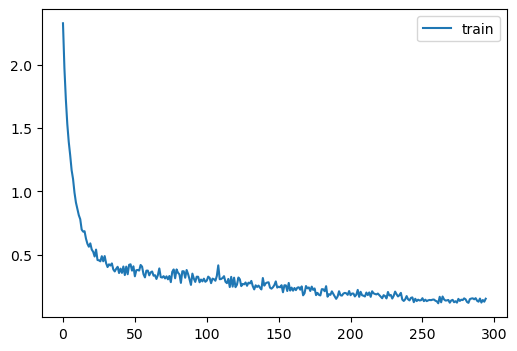

In [46]:
learn.fit(epochs)

It is interesting to note that our basic resnet yields better results than state of the art resnet architecture.